# Homework 3: Brain MRI Classification & Segmentation

> David Mikhael


## Loading Kaggle Dataset
We can download the Brain MRI Segmentation dataset from Kaggle:
https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

In [ ]:
!curl -L -o lgg-mri-segmentation.zip https://www.kaggle.com/api/v1/datasets/download/mateuszbuda/lgg-mri-segmentation
!unzip -qo lgg-mri-segmentation.zip "lgg-mri-segmentation/kaggle_3m/*"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  713M  100  713M    0     0  80.8M      0  0:00:08  0:00:08 --:--:-- 60.7M


In [ ]:
import os
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

import torch
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

##Visualization
Let's write code that will allow us to read and display the .tiff files

In [ ]:
import numpy as np
import tifffile as tiff

def image_file_to_arr(filename: str) -> np.ndarray:
    """
    Reads a .tiff file and returns a numpy array.

    Args:
        filename (str): Path to the .tiff image file.

    Returns:
        np.ndarray: The image as a NumPy array.
    """
    return tiff.imread(filename)

In [ ]:
def mask_file_to_arr(filename: str) -> np.ndarray:
    """
    Reads a .tiff mask file and returns a NumPy array.

    Args:
        filename (str): Path to the .tiff mask file.

    Returns:
        np.ndarray: The mask as a NumPy array.
    """
    return tiff.imread(filename)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

def plot_subject_data(img: np.ndarray, gt_seg: np.ndarray = None, pred_seg: np.ndarray = None):
    """
    Plots a three-channel image with optional ground truth and predicted segmentation contours.

    Args:
        img (np.ndarray): The input image (HxWx3).
        gt_seg (np.ndarray, optional): Ground truth segmentation mask (HxW). Defaults to None.
        pred_seg (np.ndarray, optional): Predicted segmentation mask (HxW). Defaults to None.
    """
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Display the original image
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Overlay Ground Truth Segmentation
    if gt_seg is not None:
        ax[1].imshow(img)
        contours = measure.find_contours(gt_seg, 0.5)
        for contour in contours:
            ax[1].plot(contour[:, 1], contour[:, 0], color="g", linewidth=2)
        ax[1].set_title("Ground Truth Segmentation")
        ax[1].axis("off")
    else:
        ax[1].axis("off")

    # Overlay Predicted Segmentation
    if pred_seg is not None:
        ax[2].imshow(img)
        contours = measure.find_contours(pred_seg, 0.5)
        for contour in contours:
            ax[2].plot(contour[:, 1], contour[:, 0], color="r", linewidth=2)
        ax[2].set_title("Predicted Segmentation")
        ax[2].axis("off")
    else:
        ax[2].axis("off")

    plt.tight_layout()
    plt.show()


Let's try to display one of the subjects in the dataset

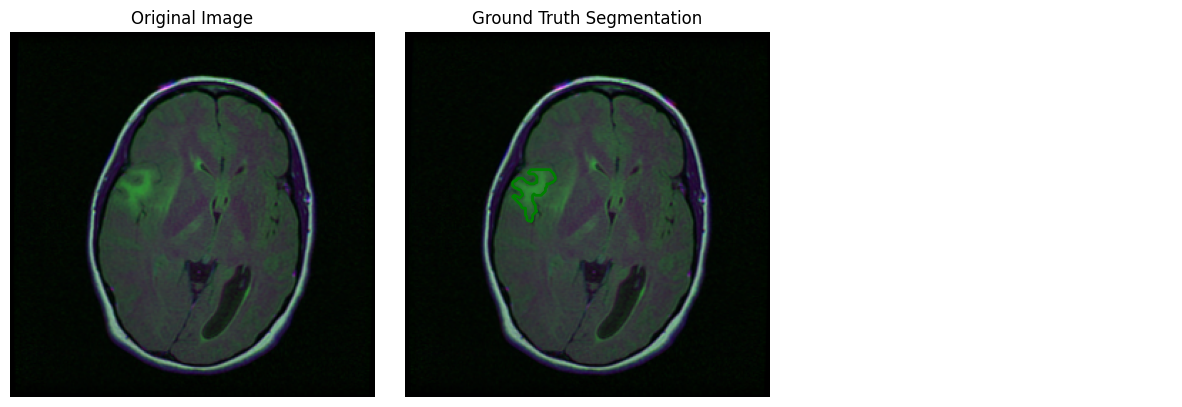

In [ ]:
subject_img = image_file_to_arr("/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_23.tif")
mask_img = mask_file_to_arr("lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_23_mask.tif")
plot_subject_data(subject_img, mask_img)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Split our dataset
Let's split our dataset into training, validation, and test sets (70% - 10% - 20%)

In [ ]:
import os
import numpy as np
from typing import List, Tuple

def get_subjects(datapath: str) -> List[str]:
    """
    Returns a list of unique subjects in the dataset.

    Args:
        datapath (str): Path to the dataset directory.

    Returns:
        List[str]: List of subject names.
    """
    subjects = []

    # Traverse the dataset directory
    for folder in os.listdir(datapath):
        folder_path = os.path.join(datapath, folder)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            subjects.append(folder)

    return sorted(subjects)  # Sorted for consistency


In [ ]:
def train_val_test_split(subjects: List[str], train_ratio=0.8, val_ratio=0.1, test_ratio=0.1) -> Tuple[List[str], List[str], List[str]]:
    """
    Splits the list of subjects into training, validation, and test sets.

    Args:
        subjects (List[str]): List of subject IDs.
        train_ratio (float): Fraction of data to use for training.
        val_ratio (float): Fraction of data to use for validation.
        test_ratio (float): Fraction of data to use for testing.

    Returns:
        Tuple[List[str], List[str], List[str]]: Train, validation, and test subject lists.
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."

    np.random.shuffle(subjects)  # Shuffle subjects before splitting

    total_subjects = len(subjects)
    train_size = int(train_ratio * total_subjects)
    val_size = int(val_ratio * total_subjects)

    train_subjects = subjects[:train_size]
    val_subjects = subjects[train_size:train_size + val_size]
    test_subjects = subjects[train_size + val_size:]

    return train_subjects, val_subjects, test_subjects

In [ ]:
random.seed(42)
train_subjects, val_subjects, test_subjects = train_val_test_split(get_subjects("lgg-mri-segmentation/kaggle_3m"))
print(f"Train subjects: {len(train_subjects)}")
print(f"Validation subjects: {len(val_subjects)}")
print(f"Test subjects: {len(test_subjects)}")
print(test_subjects)

Train subjects: 88
Validation subjects: 11
Test subjects: 11
['TCGA_DU_7302_19911203', 'TCGA_HT_7884_19980913', 'TCGA_DU_7300_19910814', 'TCGA_HT_8113_19930809', 'TCGA_HT_A5RC_19990831', 'TCGA_CS_6188_20010812', 'TCGA_FG_8189_20030516', 'TCGA_CS_5395_19981004', 'TCGA_DU_6401_19831001', 'TCGA_DU_8162_19961029', 'TCGA_DU_6400_19830518']


## Pytorch Dataset
Let's start writing code to load our data for training

Let's write some basic utilities to get the files for the subjects and the data from those files

In [ ]:
import os
from typing import List, Tuple

def get_files(datapath: str, subjects: List[str]) -> Tuple[List[str], List[str]]:
    """
    Returns a list of image files and a list of mask files for the given subjects.

    Args:
        datapath (str): Path to the dataset directory.
        subjects (List[str]): List of subject folder names.

    Returns:
        Tuple[List[str], List[str]]: A tuple containing:
            - List of image file paths
            - List of corresponding mask file paths
    """
    img_files = []
    mask_files = []

    for subject in subjects:
        subject_path = os.path.join(datapath, subject)

        if not os.path.isdir(subject_path):
            continue  # Skip if it's not a directory

        # List all .tif or .tiff files in the subject folder
        all_files = sorted(os.listdir(subject_path))  # Sort to maintain order

        # Separate images and masks based on naming convention
        for file in all_files:
            if file.endswith(".tif") or file.endswith(".tiff"):
                file_path = os.path.join(subject_path, file)

                if "mask" in file.lower():
                    mask_files.append(file_path)
                else:
                    img_files.append(file_path)

    # Ensure image and mask files match up (same number of slices)
    img_files.sort()
    mask_files.sort()

    return img_files, mask_files


In [ ]:
print(train_subjects[0])
test_img_files, test_mask_files = get_files("lgg-mri-segmentation/kaggle_3m", [test_subjects[0]])
train_img_files, train_mask_files = get_files("lgg-mri-segmentation/kaggle_3m", [train_subjects[0]])
val_img_files, val_mask_files = get_files("lgg-mri-segmentation/kaggle_3m", [val_subjects[0]])
print(test_img_files)
print(test_mask_files)

TCGA_HT_A61A_20000127
['lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_1.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_10.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_11.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_12.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_13.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_14.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_15.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_16.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_17.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_18.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_19.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_DU_730

In [ ]:
def get_img_data(file: str) -> np.ndarray:
    """
    Reads a .tiff image file and returns a numpy array in shape [3, H, W].

    Args:
        file (str): Path to the image file.

    Returns:
        np.ndarray: The image as a NumPy array with shape [3, H, W].
    """
    img = tiff.imread(file)  # Load image

    if img.ndim == 2:  # If grayscale, replicate across 3 channels
        img = np.stack([img] * 3, axis=0)
    elif img.ndim == 3 and img.shape[-1] == 3:  # Convert HxWx3 to 3xHxW
        img = np.transpose(img, (2, 0, 1))

    return img.astype(np.float32)  # Convert to float32 for consistency

In [ ]:
def get_mask_data(file: str) -> np.ndarray:
    """
    Reads a .tiff mask file and returns a numpy array in shape [1, H, W].

    Args:
        file (str): Path to the mask file.

    Returns:
        np.ndarray: The mask as a NumPy array with shape [1, H, W].
    """
    mask = tiff.imread(file)  # Load mask

    if mask.ndim == 2:  # Ensure [1, H, W]
        mask = np.expand_dims(mask, axis=0)

    return mask.astype(np.uint8)  # Convert to uint8 (binary mask)

## Data Normalization
We need to normalize our data. One way is to subtract the mean and divide by the standard deviation. Here we find the per-channel global mean and standard deviation for our training dataset. We will also apply this normalization to the validation and testing datasets.

In [ ]:
# Get train img files
train_img_files = train_img_files
# Get the train images
train_imgs = [get_img_data(file) for file in train_img_files]  # List of [3, H, W] images

# Convert to a single NumPy array: [N, 3, H, W]
train_imgs_np = np.stack(train_imgs, axis=0)

# Compute mean and std across channels
IMAGE_MEAN = np.mean(train_imgs_np, axis=(0, 2, 3))  # Per-channel mean
IMAGE_STD = np.std(train_imgs_np, axis=(0, 2, 3))    # Per-channel std dev

# Print results
print("IMAGE_MEAN:", IMAGE_MEAN)  # Expected shape: (3,)
print("IMAGE_STD:", IMAGE_STD)    # Expected shape: (3,)

IMAGE_MEAN: [14.513306  5.299171 15.128973]
IMAGE_STD: [22.76392   8.917999 24.474207]


# Custom transforms
Write our own custom transform classes

In [ ]:
class RandFlip():
    def __init__(self, p: float = 0.5):
        self.p = p

    def forward(self, img: np.ndarray, mask: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Randomly flips the image and mask horizontally and/or vertically with probability `p`.
        """
        if random.random() < self.p:
            img = np.flip(img, axis=-1)  # Flip horizontally (last dimension is width)
            if mask is not None:
                mask = np.flip(mask, axis=-1)

        if random.random() < self.p:
            img = np.flip(img, axis=-2)  # Flip vertically (second-last dimension is height)
            if mask is not None:
                mask = np.flip(mask, axis=-2)

        return img, mask


In [ ]:
class RandRotate():
    def __init__(self):
        pass

    def forward(self, img: np.ndarray, mask: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Randomly rotates the image and mask by 0, 90, 180, or 270 degrees.
        """
        num_rot = random.randint(0, 3)  # 0: no rotation, 1: 90°, 2: 180°, 3: 270°
        img = np.rot90(img, k=num_rot, axes=(-2, -1))  # Rotate along height & width

        if mask is not None:
            mask = np.rot90(mask, k=num_rot, axes=(-2, -1))

        return img, mask

In [ ]:
class Normalize():
    def __init__(self, image_mean: np.ndarray, image_std: np.ndarray):
        self.image_mean = image_mean[:, None, None]  # Reshape for broadcasting
        self.image_std = image_std[:, None, None]

    def forward(self, img: np.ndarray, mask: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Normalizes the image using the given mean and standard deviation.
        """
        img = (img - self.image_mean) / self.image_std  # Normalize image

        return img, mask

In [ ]:
class Compose():
    def __init__(self, transforms: List):
        self.transforms = transforms

    def forward(self, img: np.ndarray, mask: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Applies a list of transformations in sequence.
        """
        for transform in self.transforms:
            img, mask = transform.forward(img, mask)

        return img, mask

## Pytorch Dataset
Make a pytorch dataset for classification

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from typing import List

class TumorClassification(Dataset):
    def __init__(self, img_dir: str, subjects: List[str], transform=None):
        """
        Args:
            img_dir (str): Directory containing the images.
            subjects (List[str]): List of subjects to use.
            transform (callable, optional): Transformations to apply to the images.

        Precomputes the labels but loads images dynamically.
        """
        self.img_dir = img_dir
        self.subjects = subjects
        self.transform = transform

        # Get image and mask file paths
        self.img_files, self.mask_files = get_files(img_dir, subjects)

        # Compute labels: 1 if mask contains a tumor (nonzero pixels), else 0
        self.labels = np.array([1 if np.any(get_mask_data(mask)) else 0 for mask in self.mask_files], dtype=np.int64)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        """
        Returns:
            img (torch.Tensor): Image tensor [3, H, W].
            label (torch.Tensor): Binary tumor label (0: No Tumor, 1: Tumor).
        """
        # Load image
        img = get_img_data(self.img_files[idx])  # Shape: [3, H, W]

        # Get label
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        # Apply transformations
        if self.transform:
            img, _ = self.transform.forward(img)  # Only transform the image

        # Convert to torch tensor
        img = torch.tensor(img.copy(), dtype=torch.float32)  # Use .copy() to avoid memory issues

        return img, label


Let's test how our dataset works

Image Shape: torch.Size([3, 256, 256])
Mask Shape: (1, 256, 256)
Label Shape: torch.Size([])
Max Pixel Value: tensor(241.)
Min Pixel Value: tensor(0.)
Label: tensor(1)


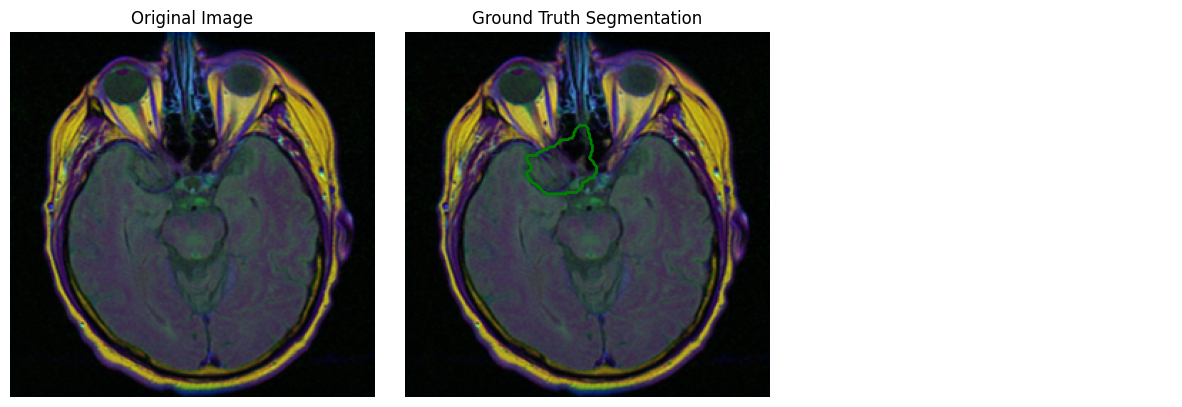

In [ ]:
train_dataset = TumorClassification(
    img_dir="lgg-mri-segmentation/kaggle_3m",
    subjects=train_subjects,
    transform=None  # Apply normalization
)

# Load an example image, mask, and label
example_img, example_label = train_dataset[1]

# Load the corresponding mask file
example_mask_file = train_dataset.mask_files[1]
example_mask = get_mask_data(example_mask_file)  # Shape: [1, H, W]

# Print image and label details
print("Image Shape:", example_img.shape)  # Expected: [3, 256, 256]
print("Mask Shape:", example_mask.shape)  # Expected: [1, 256, 256]
print("Label Shape:", example_label.shape)  # Expected: [] (scalar)
print("Max Pixel Value:", torch.max(example_img))
print("Min Pixel Value:", torch.min(example_img))
print("Label:", example_label)

# Convert image & mask to numpy for visualization
img_np = example_img.numpy().transpose((1, 2, 0))  # Convert [3, H, W] → [H, W, 3]
mask_np = example_mask.squeeze(0)  # Convert [1, H, W] → [H, W]


# Rescale for matplotlib (0-1 range)
img_display = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Plot the corrected image
plot_subject_data(img_display, mask_np, None)

# Clean up
del train_dataset


## ResNet Model
Let's write code to make our ResNet Classification model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SkipBlock(nn.Module):
    """
    Skip connection block for the ResNet architecture.
    Uses identity mapping if dimensions match, otherwise applies a 1x1 convolution.
    """
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        self.skip = nn.Identity() if (in_channels == out_channels and stride == 1) else nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.skip(x)

In [ ]:
class ConvBlock(nn.Module):
    """
    Convolutional block for the ResNet architecture.
    Applies Conv2D → BatchNorm → ReLU → Conv2D → BatchNorm.
    """
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_block(x)

In [ ]:
class ResBlock(nn.Module):
    """
    Residual block that combines ConvBlock and SkipBlock.
    Ensures skip connection dimensions match.
    """
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels, stride)
        self.skip = SkipBlock(in_channels, out_channels, stride)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.conv(x) + self.skip(x))

In [ ]:
class ResNet(nn.Module):
    """
    ResNet architecture with configurable input and output channels.
    """
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Define ResNet Blocks (3 Stages)
        self.res_blocks = nn.Sequential(
            ResBlock(64, 64),
            ResBlock(64, 128, stride=2),
            ResBlock(128, 256, stride=2),
            ResBlock(256, 512, stride=2)
        )

        # Global Average Pooling & Fully Connected Layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.output = nn.Linear(512, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ResNet architecture.
        """
        x = self.initial_conv(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)  # Shape: [batch_size, 512, 1, 1]
        x = torch.flatten(x, 1)  # Flatten before FC layer
        x = self.output(x)  # Fully connected layer

        return x

Let's double check our model works

In [ ]:
X = torch.randn(1, 3, 256, 256)
model = ResNet(3, 1)
Y = model(X)
print(Y.shape)
del model

torch.Size([1, 1])


## Training the Classification Model
Let's write a function that will train the model and validate it after every epoch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

def run_classification_training(
    model,
    train_dataset,
    val_dataset,
    batch_size: int = 32,
    n_epochs: int = 50,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,  # L2 Regularization
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    early_stopping_patience: int = -1,
    grad_clip: float = 1.0,  # Gradient clipping value
    lr_scheduler_step: int = 10,  # Step size for LR scheduler
    lr_scheduler_gamma: float = 0.5,  # Decay factor for LR scheduler
):
    """
    Train a ResNet-based binary classifier with optional early stopping and gradient clipping.

    Args:
        model (torch.nn.Module): The ResNet model to train.
        train_dataset (Dataset): Training dataset.
        val_dataset (Dataset): Validation dataset.
        batch_size (int): Batch size for training and validation.
        n_epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.
        weight_decay (float): L2 regularization strength.
        device (torch.device): Device to train on (CPU or GPU).
        early_stopping_patience (int): Number of epochs to wait before stopping training if no improvement.
        grad_clip (float): Gradient clipping threshold to prevent exploding gradients.
        lr_scheduler_step (int): Number of epochs before reducing learning rate.
        lr_scheduler_gamma (float): Factor by which learning rate is reduced.

    Returns:
        Tuple containing:
            - best_model (torch.nn.Module): The best trained model.
            - train_loss_history (List[float]): Training loss per epoch.
            - train_acc_history (List[float]): Training accuracy per epoch.
            - val_loss_history (List[float]): Validation loss per epoch.
            - val_acc_history (List[float]): Validation accuracy per epoch.
    """

    # **Initialize DataLoaders** for efficient batch processing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Store metrics
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    # Move model to device (GPU/CPU)
    model = model.to(device)

    # **Adam optimizer with weight decay (L2 Regularization)**
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # **Loss function: Binary Cross Entropy (for binary classification)**
    loss_fn = nn.BCEWithLogitsLoss()

    # **Learning Rate Scheduler**
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=lr_scheduler_gamma)

    # **Early stopping initialization**
    best_val_loss = float("inf")
    patience_counter = 0
    best_model = None

    for epoch in range(n_epochs):
        # **Training Phase**
        model.train()
        train_loss, correct_preds, total_samples = 0.0, 0, 0

        for img, label in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Training]"):
            # Move data to the correct device
            img, label = img.to(device, non_blocking=True), label.to(device, non_blocking=True).float()

            # **Ensure label shape is correct**
            label = label.unsqueeze(1)  # Make sure label has shape [batch_size, 1]

            # Reset gradients
            optimizer.zero_grad()

            # **Forward pass**
            output = model(img)

            # Compute loss
            loss = loss_fn(output, label)

            # Backward pass
            loss.backward()

            # **Gradient Clipping**
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # Update weights
            optimizer.step()

            # **Track training loss**
            train_loss += loss.item() * img.size(0)

            # **Compute accuracy**
            preds = (torch.sigmoid(output) > 0.5).long()
            correct_preds += (preds == label.long()).sum().item()
            total_samples += label.size(0)

        # Compute average loss and accuracy
        train_loss /= total_samples
        train_acc = correct_preds / total_samples

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        print(f"Train Epoch {epoch+1} Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}")

        # **Validation Phase**
        model.eval()
        val_loss, correct_preds, total_samples = 0.0, 0, 0

        with torch.no_grad():
            for img, label in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Validation]"):
                img, label = img.to(device, non_blocking=True), label.to(device, non_blocking=True).float()
                label = label.unsqueeze(1)  # Ensure label shape is [batch_size, 1]

                # **Forward pass**
                output = model(img)

                # Compute loss
                loss = loss_fn(output, label)
                val_loss += loss.item() * img.size(0)

                # **Compute accuracy**
                preds = (torch.sigmoid(output) > 0.5).long()
                correct_preds += (preds == label.long()).sum().item()
                total_samples += label.size(0)

        # Compute average validation loss and accuracy
        val_loss /= total_samples
        val_acc = correct_preds / total_samples

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Val Epoch {epoch+1} Loss: {val_loss:.4f} Accuracy: {val_acc:.4f}")

        # **Adjust Learning Rate**
        scheduler.step()

        # **Early Stopping Mechanism**
        if early_stopping_patience > 0:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model = model.state_dict()  # Save best model weights
                print("🔥 Best model updated!")
            else:
                patience_counter += 1
                print(f"⏳ Early stopping counter: {patience_counter}/{early_stopping_patience}")

            if patience_counter >= early_stopping_patience:
                print("🛑 Early stopping triggered. Stopping training.")
                break

    # Load best model before returning
    if best_model is not None:
        model.load_state_dict(best_model)

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history


Let's run training with 50 epochs, batch size of 32, learning rate of 1e-3, early stopping patience of 20, and some simple augmentations

In [ ]:
train_dataset = TumorClassification(
    img_dir="lgg-mri-segmentation/kaggle_3m",
    subjects=train_subjects,
    transform=None
)

val_dataset = TumorClassification(
    img_dir="lgg-mri-segmentation/kaggle_3m",
    subjects=val_subjects,
    transform=None
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")
model = ResNet(3, 1)
trained_model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = run_classification_training(model, train_dataset, val_dataset, device=device, n_epochs=50, lr=1e-3, early_stopping_patience=5)

torch.save(trained_model.cpu().state_dict(), "classification-best-model.pth")

Device is cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/50 [Training]:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/50 [Training]: 100%|

Train Epoch 1 Loss: 0.5893 Accuracy: 0.6935


Epoch 1/50 [Validation]: 100%|██████████| 12/12 [00:01<00:00, 10.51it/s]


Val Epoch 1 Loss: 0.7608 Accuracy: 0.6291
🔥 Best model updated!


Epoch 2/50 [Training]: 100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


Train Epoch 2 Loss: 0.5324 Accuracy: 0.7127


Epoch 2/50 [Validation]: 100%|██████████| 12/12 [00:01<00:00, 11.47it/s]


Val Epoch 2 Loss: 0.5161 Accuracy: 0.7582
🔥 Best model updated!


Epoch 3/50 [Training]: 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


Train Epoch 3 Loss: 0.5057 Accuracy: 0.7433


Epoch 3/50 [Validation]: 100%|██████████| 12/12 [00:01<00:00,  9.87it/s]


Val Epoch 3 Loss: 0.5630 Accuracy: 0.7280
⏳ Early stopping counter: 1/5


Epoch 4/50 [Training]: 100%|██████████| 100/100 [00:10<00:00,  9.16it/s]


Train Epoch 4 Loss: 0.5073 Accuracy: 0.7367


Epoch 4/50 [Validation]: 100%|██████████| 12/12 [00:01<00:00, 10.42it/s]


Val Epoch 4 Loss: 0.5282 Accuracy: 0.7390
⏳ Early stopping counter: 2/5


Epoch 5/50 [Training]: 100%|██████████| 100/100 [00:10<00:00,  9.75it/s]


Train Epoch 5 Loss: 0.4827 Accuracy: 0.7597


Epoch 5/50 [Validation]: 100%|██████████| 12/12 [00:01<00:00, 11.02it/s]


Val Epoch 5 Loss: 0.4781 Accuracy: 0.7335
🔥 Best model updated!


Epoch 6/50 [Training]: 100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


Train Epoch 6 Loss: 0.4583 Accuracy: 0.7884


Epoch 6/50 [Validation]: 100%|██████████| 12/12 [00:01<00:00,  7.74it/s]


Val Epoch 6 Loss: 0.5005 Accuracy: 0.7445
⏳ Early stopping counter: 1/5


Epoch 7/50 [Training]: 100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


Train Epoch 7 Loss: 0.4195 Accuracy: 0.8149


Epoch 7/50 [Validation]: 100%|██████████| 12/12 [00:01<00:00,  7.52it/s]


Val Epoch 7 Loss: 0.4925 Accuracy: 0.8022
⏳ Early stopping counter: 2/5


Epoch 8/50 [Training]: 100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


Train Epoch 8 Loss: 0.4133 Accuracy: 0.8209


Epoch 8/50 [Validation]: 100%|██████████| 12/12 [00:01<00:00, 11.31it/s]


Val Epoch 8 Loss: 0.4916 Accuracy: 0.7335
⏳ Early stopping counter: 3/5


Epoch 9/50 [Training]: 100%|██████████| 100/100 [00:10<00:00,  9.69it/s]


Train Epoch 9 Loss: 0.3885 Accuracy: 0.8344


Epoch 9/50 [Validation]: 100%|██████████| 12/12 [00:01<00:00, 10.94it/s]


Val Epoch 9 Loss: 0.4827 Accuracy: 0.7940
⏳ Early stopping counter: 4/5


Epoch 10/50 [Training]: 100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


Train Epoch 10 Loss: 0.3856 Accuracy: 0.8379


Epoch 10/50 [Validation]: 100%|██████████| 12/12 [00:01<00:00, 10.92it/s]

Val Epoch 10 Loss: 0.4796 Accuracy: 0.7473
⏳ Early stopping counter: 5/5
🛑 Early stopping triggered. Stopping training.


Let's plot the training curves we get

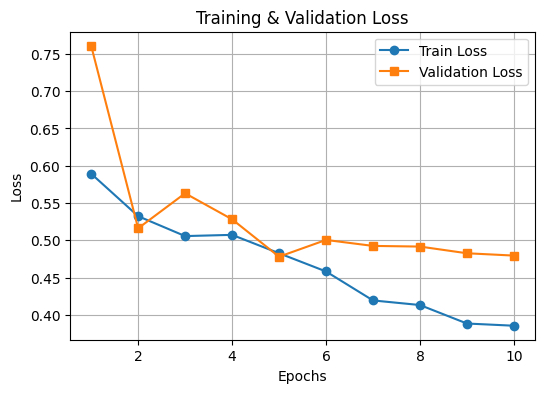

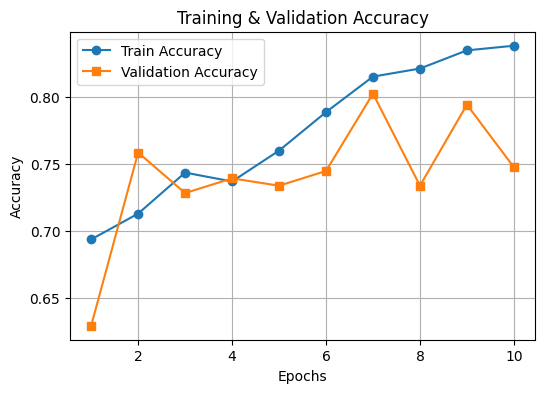

In [ ]:
import matplotlib.pyplot as plt

# Example data (Replace these with your actual values)
epochs = list(range(1, len(train_loss_history) + 1))  # Ensure `train_loss` exists
train_loss = train_loss_history  # Replace with actual training loss values
val_loss = val_loss_history  # Replace with actual validation loss values

train_acc = train_acc_history  # Replace with actual training accuracy values
val_acc = val_acc_history  # Replace with actual validation accuracy values

# Plot Classification Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("classification-loss.png", bbox_inches='tight', pad_inches=0.05, dpi=600)
plt.show()
plt.close()

# Plot Classification Accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("classification-acc.png", bbox_inches='tight', pad_inches=0.05, dpi=600)
plt.show()
plt.close()


## Evaluation on Test Dataset

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def run_classification_testing(
    model,
    test_dataset,
    batch_size: int = 32,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    """
    Evaluate a trained classification model on a test dataset.

    Args:
        model (torch.nn.Module): Trained model to evaluate.
        test_dataset (Dataset): Test dataset.
        batch_size (int): Batch size for evaluation.
        device (torch.device): Device to run inference on.

    Returns:
        Tuple[List[float], List[int]]: Model predictions and ground truth labels.
    """

    # ✅ Initialize DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # ✅ Move model to device and set to evaluation mode
    model = model.to(device)
    model.eval()

    # ✅ Store outputs and targets
    outputs = []
    targets = []

    # ✅ Disable gradient computation
    with torch.no_grad():
        for img, label in tqdm(test_loader, desc="Evaluating on Test Set"):
            img = img.to(device)
            label = label.to(device)

            # ✅ Forward pass
            output = model(img)

            # ✅ Convert logits to probabilities (for binary classification)
            prob = torch.sigmoid(output).squeeze().cpu().numpy()
            outputs.extend(prob.tolist())

            # ✅ Store ground truth labels
            targets.extend(label.cpu().numpy().tolist())

    return outputs, targets


Let's test the model

In [ ]:
test_dataset = TumorClassification(
    img_dir="lgg-mri-segmentation/kaggle_3m",
    subjects=test_subjects,
    transform=None
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")
outputs, targets = run_classification_testing(trained_model, test_dataset, device=device)

Device is cuda


Evaluating on Test Set: 100%|██████████| 13/13 [00:01<00:00, 10.31it/s]


Let's calculate the ROC curve & AUROC and accuracy

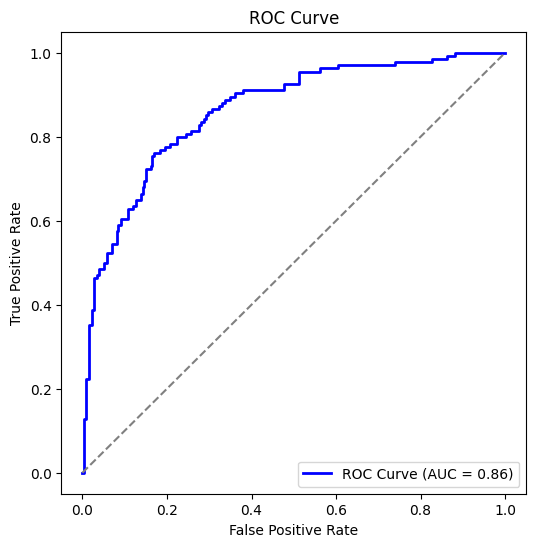

AUC: 0.8644
Accuracy: 0.7868


In [ ]:
predictions = outputs
ground_truth = targets

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score

# Convert probabilities to binary predictions
pred_labels = [1 if p > 0.5 else 0 for p in predictions]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(ground_truth, predictions)
roc_auc = auc(fpr, tpr)

# Compute accuracy
acc = accuracy_score(ground_truth, pred_labels)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

# Save plot
plt.savefig("classification-roc.png", bbox_inches='tight', pad_inches=0.05, dpi=600)
plt.show()
plt.close()

# Print results
print(f"AUC: {roc_auc:.4f}")
print(f"Accuracy: {acc:.4f}")


Let's calculate the PR curve & AUPR and compute the F1 score

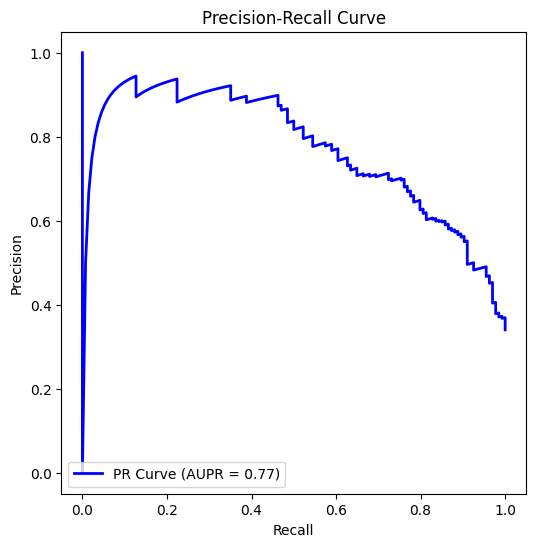

AUPR: 0.7704
F1 Score: 0.7123


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

# Convert probabilities to binary predictions
pred_labels = [1 if p > 0.5 else 0 for p in predictions]

# Compute Precision-Recall curve and AUPR
precision, recall, _ = precision_recall_curve(ground_truth, predictions)
pr_auc = average_precision_score(ground_truth, predictions)

# Compute F1 Score
f1 = f1_score(ground_truth, pred_labels)

# Plot PR Curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color="blue", lw=2, label=f"PR Curve (AUPR = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")

# Save plot
plt.savefig("classification-pr.png", bbox_inches='tight', pad_inches=0.05, dpi=600)
plt.show()
plt.close()

# Print results
print(f"AUPR: {pr_auc:.4f}")
print(f"F1 Score: {f1:.4f}")


Let's calculate the confusion matrix and compute the sensitivity and specificity

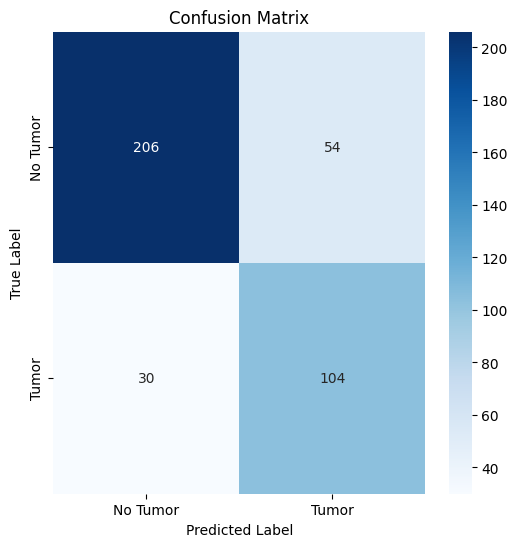

Sensitivity: 0.7761
Specificity: 0.7923


In [ ]:
pred_labels = [1 if p > 0.5 else 0 for p in predictions]

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
C = confusion_matrix(ground_truth, pred_labels)

# Compute sensitivity (recall for class 1) and specificity (recall for class 0)
TP = C[1, 1]  # True Positives
FN = C[1, 0]  # False Negatives
FP = C[0, 1]  # False Positives
TN = C[0, 0]  # True Negatives

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # Recall for positive class
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0  # Recall for negative class

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(C, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Save plot
plt.savefig("classification-confusion-matrix.png", bbox_inches='tight', pad_inches=0.05, dpi=600)
plt.show()
plt.close()

# Print results
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


## Tumor Segmentation
Let's try to segment the tumor from the MRI images

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from typing import List

class TumorSegmentation(Dataset):
    """
    PyTorch Dataset for loading MRI images and their corresponding segmentation masks.
    """
    def __init__(self, img_dir: str, subjects: List[str], transform=None):
        """
        Args:
            img_dir (str): Directory containing the dataset.
            subjects (List[str]): List of subject names.
            transform (callable, optional): Optional transformations to apply.
        """
        self.img_dir = img_dir
        self.subjects = subjects
        self.transform = transform

        # Get file paths for images and corresponding masks
        self.img_files, self.mask_files = get_files(img_dir, subjects)

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.img_files)

    def __getitem__(self, idx):
        """
        Retrieves an image-mask pair and applies transformations.
        """
        # Load the image and mask
        img = get_img_data(self.img_files[idx])
        mask = get_mask_data(self.mask_files[idx])

        # Apply transformations (if any)
        if self.transform:
            img, mask = self.transform.forward(img, mask)

        # Convert to PyTorch tensors
        img = torch.tensor(img.copy()).float()
        mask = torch.tensor(mask.copy()).float()

        return img, mask


Let's test if the train dataset is working properly

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
tensor(20.9353)
tensor(-0.6376)
tensor(255.)
tensor(0.)


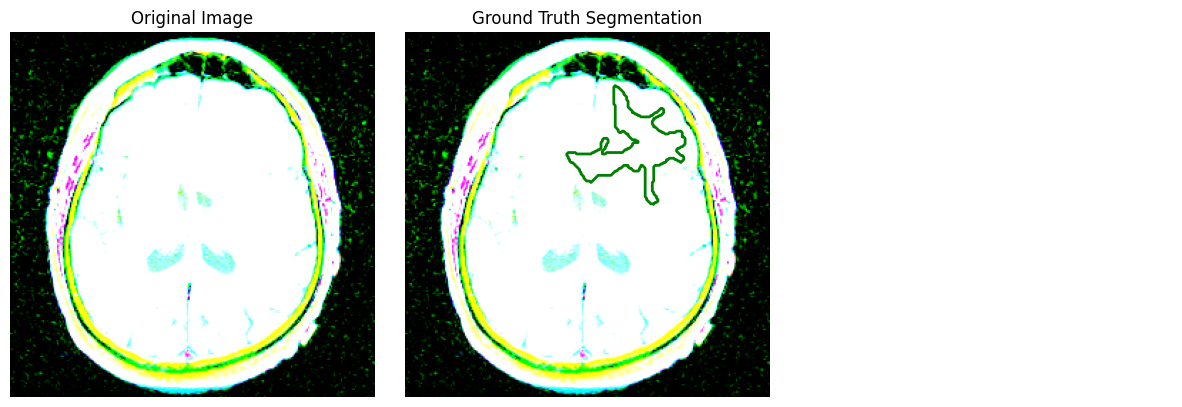

In [ ]:
train_dataset = TumorSegmentation(
    img_dir="lgg-mri-segmentation/kaggle_3m",
    subjects=train_subjects,
    transform=Compose([
        RandFlip(),
        RandRotate(),
        Normalize(IMAGE_MEAN, IMAGE_STD),
    ])
)
example_img, example_mask = train_dataset[5]
print(example_img.shape)
print(example_mask.shape)
print(torch.max(example_img))
print(torch.min(example_img))
print(torch.max(example_mask))
print(torch.min(example_mask))
del train_dataset
plot_subject_data(example_img.numpy().transpose((1, 2, 0)), example_mask.numpy()[0])


## UNET Code
Let's write code for the UNET architecture

In [ ]:
class DoubleConvBlock(nn.Module):
    """
    Double convolution block for the UNET architecture.
    Applies: Conv2D -> BatchNorm2D -> ReLU -> Conv2D -> BatchNorm2D -> ReLU
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_block(x)

In [ ]:
class UnetEncoderBlock(nn.Module):
    """
    Encoder block for the UNET architecture.
    Applies: DoubleConvBlock -> MaxPooling2D
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv_block = DoubleConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            z (torch.Tensor): Output after DoubleConvBlock (for skip connection).
            output (torch.Tensor): Output after pooling.
        """
        z = self.conv_block(x)
        output = self.pool(z)
        return z, output

In [ ]:
class UnetDecoderBlock(nn.Module):
    """
    Decoder block for the UNET architecture.
    Applies: ConvTranspose2D -> Concatenation with Skip Connection -> DoubleConvBlock
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = DoubleConvBlock(in_channels, out_channels)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the decoder block.
        """
        x = self.upsample(x)

        # Ensure shapes match before concatenation
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])

        x = torch.cat([skip, x], dim=1)  # Concatenation along channel dimension
        x = self.conv_block(x)
        return x

In [ ]:
class UNet(nn.Module):
    """
    Full UNET Architecture.
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Encoder Path
        self.enc1 = UnetEncoderBlock(in_channels, 64)
        self.enc2 = UnetEncoderBlock(64, 128)
        self.enc3 = UnetEncoderBlock(128, 256)
        self.enc4 = UnetEncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = DoubleConvBlock(512, 1024)

        # Decoder Path
        self.dec4 = UnetDecoderBlock(1024, 512)
        self.dec3 = UnetDecoderBlock(512, 256)
        self.dec2 = UnetDecoderBlock(256, 128)
        self.dec1 = UnetDecoderBlock(128, 64)

        # Final Output Layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the UNET architecture.
        """
        # Encoder
        s1, x = self.enc1(x)
        s2, x = self.enc2(x)
        s3, x = self.enc3(x)
        s4, x = self.enc4(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder with skip connections
        x = self.dec4(x, s4)
        x = self.dec3(x, s3)
        x = self.dec2(x, s2)
        x = self.dec1(x, s1)

        # Final output
        x = self.final_conv(x)

        return x

Check to see if model works

In [ ]:
X = torch.randn(1, 3, 256, 256)
model = UNet(3, 1)
Y = model(X)
print(Y.shape)
del model

torch.Size([1, 1, 256, 256])


## DICE Loss
This code implements the DICE loss

In [ ]:
def dice_score_fn(pred: torch.Tensor, target: torch.Tensor, smooth: float = 1.0) -> torch.Tensor:
    """
    Computes the mean DICE Score for a batch of predictions and targets.

    Args:
        pred (torch.Tensor): Model predictions (logits or probabilities), shape [B, 1, H, W].
        target (torch.Tensor): Ground truth segmentation masks, shape [B, 1, H, W].
        smooth (float): Smoothing factor to prevent division by zero.

    Returns:
        torch.Tensor: Mean DICE score for the batch.
    """
    pred = torch.sigmoid(pred)  # Convert logits to probabilities
    pred = (pred > 0.5).float()  # Binarize predictions

    intersection = (pred * target).sum(dim=(2, 3))  # Compute intersection per batch
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))  # Compute union per batch

    dice = (2.0 * intersection + smooth) / (union + smooth)  # Compute DICE score per sample
    return dice.mean()  # Average across batch

In [ ]:
def dice_loss_fn(pred: torch.Tensor, target: torch.Tensor, smooth: float = 1.0) -> torch.Tensor:
    """
    Computes the mean DICE Loss for a batch of predictions and targets.

    Args:
        pred (torch.Tensor): Model predictions (logits), shape [B, 1, H, W].
        target (torch.Tensor): Ground truth segmentation masks, shape [B, 1, H, W].
        smooth (float): Smoothing factor.

    Returns:
        torch.Tensor: Mean DICE loss for the batch.
    """
    pred = torch.sigmoid(pred)  # Convert logits to probabilities
    target = target.float()  # Ensure target is float
    target = target.clamp(0, 1)  # Ensure mask values are only 0 or 1

    intersection = (pred * target).sum(dim=(2, 3))  # Compute intersection
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))  # Compute union

    dice = (2.0 * intersection + smooth) / (union + smooth)  # Compute DICE score per sample
    dice_loss = 1 - dice  # Loss is 1 - Dice Score

    return dice_loss.mean()  # Return mean loss across batch


In [ ]:
def dice_score_eval(pred: torch.Tensor, target: torch.Tensor, smooth: float = 1.0) -> torch.Tensor:
    """
    Computes the mean DICE Score for a batch of predictions and targets.
    Handles cases where both `pred` and `target` are empty (no tumor present).

    Args:
        pred (torch.Tensor): Model predictions (logits), shape [B, 1, H, W].
        target (torch.Tensor): Ground truth segmentation masks, shape [B, 1, H, W].
        smooth (float): Smoothing factor.

    Returns:
        torch.Tensor: Mean DICE score for the batch.
    """
    pred = torch.sigmoid(pred)  # Convert logits to probabilities
    pred = (pred > 0.5).float()  # Binarize predictions

    intersection = (pred * target).sum(dim=(2, 3))  # Compute intersection
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))  # Compute union

    # Handle cases where both prediction and ground truth are empty (no tumor)
    empty_mask = (union == 0).float()
    dice = (2.0 * intersection + smooth) / (union + smooth)

    # If both are empty, set dice to 1 (perfect score)
    dice = dice * (1 - empty_mask) + empty_mask

    return dice.mean()

## Training and validation

Now let's try to train the Unet model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

def run_training_loop(
    model,
    train_dataset,
    val_dataset,
    batch_size: int = 16,  # Increased batch size for faster training
    n_epochs: int = 50,
    lr: float = 1e-3,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    early_stopping_patience: int = -1
):
    """
    Trains a segmentation model using BCEWithLogitsLoss + Dice Loss with optimized speed.

    Args:
        model (torch.nn.Module): The UNet model.
        train_dataset (Dataset): Training dataset.
        val_dataset (Dataset): Validation dataset.
        batch_size (int): Batch size for training and validation.
        n_epochs (int): Number of training epochs.
        lr (float): Learning rate.
        device (torch.device): The device to train on.
        early_stopping_patience (int): Number of epochs to wait before stopping training if no improvement.

    Returns:
        Tuple: (best_model, train_loss_history, train_dice_history, val_loss_history, val_dice_history)
    """

    # **Initialize DataLoaders with num_workers & pin_memory for speed**
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Store training metrics
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    # Move model to device (GPU/CPU)
    model = model.to(device)

    # **Choose Adam Optimizer & Loss Functions**
    optimizer = optim.Adam(model.parameters(), lr=lr)
    bce_loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
    dice_loss_weight = 1e-2  # Weight for Dice loss

    # **Enable Mixed Precision Training**
    scaler = torch.cuda.amp.GradScaler()

    # **Early stopping initialization**
    best_val_loss = float("inf")
    patience_counter = 0
    best_model = None

    for epoch in range(n_epochs):
        # **Training Phase**
        model.train()
        train_loss = []
        train_dice = []

        for batch_idx, (img, mask) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Training]")):
            # Move data to device efficiently
            img, mask = img.to(device, non_blocking=True), mask.to(device, non_blocking=True)
            mask = mask.float().clamp(0, 1)  # Ensure target is in range [0,1]

            # Reset accumulated gradients
            optimizer.zero_grad()

            # **Forward pass with Mixed Precision**
            with torch.cuda.amp.autocast():
                output = model(img)  # Output is logits (no sigmoid!)
                bce_loss = bce_loss_fn(output, mask)
                dice_loss = dice_loss_fn(output, mask)
                total_loss = bce_loss + dice_loss_weight * dice_loss  # ✅ Corrected loss calculation

            # **Backward pass & weight update with Mixed Precision**
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # **Compute DICE Score**
            dice_score = dice_score_fn(output, mask)

            # **Track statistics efficiently (avoid CPU-GPU sync)**
            train_loss.append(total_loss.detach())  # ✅ No `.item()` inside loop
            train_dice.append(dice_score.detach())

            # **Debugging Loss Values (Print First Batch of Each Epoch)**
            if batch_idx == 0:
                print(f"🔍 Epoch {epoch+1}, Batch {batch_idx}: BCE Loss = {bce_loss.item():.4f}, Dice Loss = {dice_loss.item():.4f}, Total Loss = {total_loss.item():.4f}")

        # Store epoch loss & accuracy
        train_loss_epoch = torch.mean(torch.stack(train_loss)).item()
        train_dice_epoch = torch.mean(torch.stack(train_dice)).item()
        train_loss_history.append(train_loss_epoch)
        train_dice_history.append(train_dice_epoch)

        print(f"✅ Train Epoch {epoch + 1} Loss: {train_loss_epoch:.4f} Dice Score: {train_dice_epoch:.4f}")

        # **Validation Phase**
        model.eval()
        val_loss = []
        val_dice = []

        # Disable gradient computation during validation
        with torch.no_grad():
            for img, mask in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Validation]"):
                img, mask = img.to(device, non_blocking=True), mask.to(device, non_blocking=True)
                mask = mask.float().clamp(0, 1)

                # **Forward pass**
                output = model(img)

                # Compute losses
                bce_loss = bce_loss_fn(output, mask)
                dice_loss = dice_loss_fn(output, mask)
                total_loss = bce_loss + dice_loss_weight * dice_loss

                # Compute DICE Score
                dice_score = dice_score_fn(output, mask)

                # Track metrics
                val_loss.append(total_loss.detach())
                val_dice.append(dice_score.detach())

        # Store validation loss & accuracy
        val_loss_epoch = torch.mean(torch.stack(val_loss)).item()
        val_dice_epoch = torch.mean(torch.stack(val_dice)).item()
        val_loss_history.append(val_loss_epoch)
        val_dice_history.append(val_dice_epoch)

        print(f"🔵 Val Epoch {epoch + 1} Loss: {val_loss_epoch:.4f} Dice Score: {val_dice_epoch:.4f}")

        # **Early Stopping Mechanism**
        if early_stopping_patience > 0:
            if val_loss_epoch < best_val_loss:
                best_val_loss = val_loss_epoch
                patience_counter = 0
                best_model = model.state_dict()  # Save best model weights
                print("🔥 Best model updated!")
            else:
                patience_counter += 1
                print(f"⏳ Early stopping counter: {patience_counter}/{early_stopping_patience}")

            if patience_counter >= early_stopping_patience:
                print("🛑 Early stopping triggered. Stopping training.")
                break

    # Load best model before returning
    if best_model is not None:
        model.load_state_dict(best_model)

    return model, train_loss_history, train_dice_history, val_loss_history, val_dice_history



Now we apply the training loop

In [ ]:
# Define dataset
train_dataset = TumorSegmentation(img_dir="lgg-mri-segmentation/kaggle_3m", subjects=train_subjects, transform=None)
val_dataset = TumorSegmentation(img_dir="lgg-mri-segmentation/kaggle_3m", subjects=val_subjects, transform=None)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

# Initialize U-Net model
model = UNet(in_channels=3, out_channels=1)

# Train the model
trained_model, train_loss_history, train_dice_history, val_loss_history, val_dice_history = run_training_loop(
    model,
    train_dataset,
    val_dataset,
    batch_size=16,  # Optimized batch size
    n_epochs=50,
    lr=1e-3,
    device=device,
    early_stopping_patience=10
)

# Save best model
torch.save(trained_model.cpu().state_dict(), "segmentation-best-model.pth")
print("Model training complete. Best model saved.")


Device is cuda


<ipython-input-76-7d1db6df7050>:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50 [Training]:   0%|          | 0/199 [00:00<?, ?it/s]<ipython-input-76-7d1db6df7050>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Training]:   1%|          | 1/199 [00:00<02:13,  1.48it/s]

🔍 Epoch 1, Batch 0: BCE Loss = 0.7276, Dice Loss = 0.9787, Total Loss = 0.7374


Epoch 1/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]


✅ Train Epoch 1 Loss: 0.1583 Dice Score: 0.6314


Epoch 1/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.04it/s]


🔵 Val Epoch 1 Loss: 0.0606 Dice Score: 0.6351
🔥 Best model updated!


Epoch 2/50 [Training]:   1%|          | 1/199 [00:00<01:54,  1.72it/s]

🔍 Epoch 2, Batch 0: BCE Loss = 0.0376, Dice Loss = 0.9367, Total Loss = 0.0470


Epoch 2/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]


✅ Train Epoch 2 Loss: 0.0492 Dice Score: 0.6817


Epoch 2/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.10it/s]


🔵 Val Epoch 2 Loss: 0.0454 Dice Score: 0.6612
🔥 Best model updated!


Epoch 3/50 [Training]:   1%|          | 1/199 [00:00<01:55,  1.72it/s]

🔍 Epoch 3, Batch 0: BCE Loss = 0.0178, Dice Loss = 0.9656, Total Loss = 0.0274


Epoch 3/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 3 Loss: 0.0405 Dice Score: 0.6936


Epoch 3/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.12it/s]


🔵 Val Epoch 3 Loss: 0.0398 Dice Score: 0.6815
🔥 Best model updated!


Epoch 4/50 [Training]:   1%|          | 1/199 [00:00<01:53,  1.75it/s]

🔍 Epoch 4, Batch 0: BCE Loss = 0.0240, Dice Loss = 0.8373, Total Loss = 0.0323


Epoch 4/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 4 Loss: 0.0366 Dice Score: 0.7122


Epoch 4/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.09it/s]


🔵 Val Epoch 4 Loss: 0.0361 Dice Score: 0.6995
🔥 Best model updated!


Epoch 5/50 [Training]:   1%|          | 1/199 [00:00<01:54,  1.73it/s]

🔍 Epoch 5, Batch 0: BCE Loss = 0.0275, Dice Loss = 0.9359, Total Loss = 0.0368


Epoch 5/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 5 Loss: 0.0350 Dice Score: 0.7113


Epoch 5/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.09it/s]


🔵 Val Epoch 5 Loss: 0.0345 Dice Score: 0.6826
🔥 Best model updated!


Epoch 6/50 [Training]:   1%|          | 1/199 [00:00<01:54,  1.72it/s]

🔍 Epoch 6, Batch 0: BCE Loss = 0.0287, Dice Loss = 0.8600, Total Loss = 0.0373


Epoch 6/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 6 Loss: 0.0338 Dice Score: 0.7223


Epoch 6/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.08it/s]


🔵 Val Epoch 6 Loss: 0.0339 Dice Score: 0.7090
🔥 Best model updated!


Epoch 7/50 [Training]:   1%|          | 1/199 [00:00<01:51,  1.78it/s]

🔍 Epoch 7, Batch 0: BCE Loss = 0.0329, Dice Loss = 0.7611, Total Loss = 0.0405


Epoch 7/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 7 Loss: 0.0328 Dice Score: 0.7190


Epoch 7/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.09it/s]


🔵 Val Epoch 7 Loss: 0.0343 Dice Score: 0.7132
⏳ Early stopping counter: 1/10


Epoch 8/50 [Training]:   1%|          | 1/199 [00:00<01:52,  1.76it/s]

🔍 Epoch 8, Batch 0: BCE Loss = 0.0100, Dice Loss = 0.8820, Total Loss = 0.0188


Epoch 8/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]


✅ Train Epoch 8 Loss: 0.0323 Dice Score: 0.7244


Epoch 8/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.08it/s]


🔵 Val Epoch 8 Loss: 0.0342 Dice Score: 0.7033
⏳ Early stopping counter: 2/10


Epoch 9/50 [Training]:   1%|          | 1/199 [00:00<01:51,  1.78it/s]

🔍 Epoch 9, Batch 0: BCE Loss = 0.0188, Dice Loss = 0.8327, Total Loss = 0.0271


Epoch 9/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 9 Loss: 0.0311 Dice Score: 0.7310


Epoch 9/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.12it/s]


🔵 Val Epoch 9 Loss: 0.0334 Dice Score: 0.6724
🔥 Best model updated!


Epoch 10/50 [Training]:   1%|          | 1/199 [00:00<01:51,  1.78it/s]

🔍 Epoch 10, Batch 0: BCE Loss = 0.0241, Dice Loss = 0.9432, Total Loss = 0.0336


Epoch 10/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 10 Loss: 0.0308 Dice Score: 0.7326


Epoch 10/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.09it/s]


🔵 Val Epoch 10 Loss: 0.0356 Dice Score: 0.6231
⏳ Early stopping counter: 1/10


Epoch 11/50 [Training]:   1%|          | 1/199 [00:00<01:51,  1.78it/s]

🔍 Epoch 11, Batch 0: BCE Loss = 0.0219, Dice Loss = 0.8129, Total Loss = 0.0301


Epoch 11/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]


✅ Train Epoch 11 Loss: 0.0304 Dice Score: 0.7289


Epoch 11/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.12it/s]


🔵 Val Epoch 11 Loss: 0.0325 Dice Score: 0.6942
🔥 Best model updated!


Epoch 12/50 [Training]:   1%|          | 1/199 [00:00<01:52,  1.76it/s]

🔍 Epoch 12, Batch 0: BCE Loss = 0.0213, Dice Loss = 0.7832, Total Loss = 0.0291


Epoch 12/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 12 Loss: 0.0297 Dice Score: 0.7452


Epoch 12/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.10it/s]


🔵 Val Epoch 12 Loss: 0.0336 Dice Score: 0.6938
⏳ Early stopping counter: 1/10


Epoch 13/50 [Training]:   1%|          | 1/199 [00:00<01:51,  1.77it/s]

🔍 Epoch 13, Batch 0: BCE Loss = 0.0127, Dice Loss = 0.8157, Total Loss = 0.0208


Epoch 13/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 13 Loss: 0.0288 Dice Score: 0.7399


Epoch 13/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.09it/s]


🔵 Val Epoch 13 Loss: 0.0340 Dice Score: 0.7021
⏳ Early stopping counter: 2/10


Epoch 14/50 [Training]:   1%|          | 1/199 [00:00<01:53,  1.75it/s]

🔍 Epoch 14, Batch 0: BCE Loss = 0.0073, Dice Loss = 0.8688, Total Loss = 0.0160


Epoch 14/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]


✅ Train Epoch 14 Loss: 0.0290 Dice Score: 0.7473


Epoch 14/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.08it/s]


🔵 Val Epoch 14 Loss: 0.0337 Dice Score: 0.7256
⏳ Early stopping counter: 3/10


Epoch 15/50 [Training]:   1%|          | 1/199 [00:00<01:51,  1.78it/s]

🔍 Epoch 15, Batch 0: BCE Loss = 0.0200, Dice Loss = 0.8375, Total Loss = 0.0284


Epoch 15/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]


✅ Train Epoch 15 Loss: 0.0284 Dice Score: 0.7484


Epoch 15/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.08it/s]


🔵 Val Epoch 15 Loss: 0.0319 Dice Score: 0.7232
🔥 Best model updated!


Epoch 16/50 [Training]:   1%|          | 1/199 [00:00<01:52,  1.75it/s]

🔍 Epoch 16, Batch 0: BCE Loss = 0.0201, Dice Loss = 0.7717, Total Loss = 0.0279


Epoch 16/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]


✅ Train Epoch 16 Loss: 0.0277 Dice Score: 0.7528


Epoch 16/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.09it/s]


🔵 Val Epoch 16 Loss: 0.0337 Dice Score: 0.7144
⏳ Early stopping counter: 1/10


Epoch 17/50 [Training]:   1%|          | 1/199 [00:00<01:51,  1.77it/s]

🔍 Epoch 17, Batch 0: BCE Loss = 0.0253, Dice Loss = 0.7047, Total Loss = 0.0324


Epoch 17/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 17 Loss: 0.0271 Dice Score: 0.7650


Epoch 17/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.10it/s]


🔵 Val Epoch 17 Loss: 0.0349 Dice Score: 0.6729
⏳ Early stopping counter: 2/10


Epoch 18/50 [Training]:   1%|          | 1/199 [00:00<01:51,  1.77it/s]

🔍 Epoch 18, Batch 0: BCE Loss = 0.0179, Dice Loss = 0.9023, Total Loss = 0.0269


Epoch 18/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 18 Loss: 0.0267 Dice Score: 0.7766


Epoch 18/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.10it/s]


🔵 Val Epoch 18 Loss: 0.0311 Dice Score: 0.6977
🔥 Best model updated!


Epoch 19/50 [Training]:   1%|          | 1/199 [00:00<01:53,  1.74it/s]

🔍 Epoch 19, Batch 0: BCE Loss = 0.0106, Dice Loss = 0.8529, Total Loss = 0.0191


Epoch 19/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 19 Loss: 0.0263 Dice Score: 0.7742


Epoch 19/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.09it/s]


🔵 Val Epoch 19 Loss: 0.0316 Dice Score: 0.7087
⏳ Early stopping counter: 1/10


Epoch 20/50 [Training]:   1%|          | 1/199 [00:00<01:51,  1.78it/s]

🔍 Epoch 20, Batch 0: BCE Loss = 0.0220, Dice Loss = 0.7778, Total Loss = 0.0298


Epoch 20/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 20 Loss: 0.0256 Dice Score: 0.7793


Epoch 20/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.09it/s]


🔵 Val Epoch 20 Loss: 0.0303 Dice Score: 0.7412
🔥 Best model updated!


Epoch 21/50 [Training]:   1%|          | 1/199 [00:00<01:53,  1.74it/s]

🔍 Epoch 21, Batch 0: BCE Loss = 0.0186, Dice Loss = 0.7104, Total Loss = 0.0258


Epoch 21/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]


✅ Train Epoch 21 Loss: 0.0253 Dice Score: 0.7776


Epoch 21/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.09it/s]


🔵 Val Epoch 21 Loss: 0.0323 Dice Score: 0.7104
⏳ Early stopping counter: 1/10


Epoch 22/50 [Training]:   1%|          | 1/199 [00:00<01:53,  1.75it/s]

🔍 Epoch 22, Batch 0: BCE Loss = 0.0103, Dice Loss = 0.6096, Total Loss = 0.0164


Epoch 22/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]


✅ Train Epoch 22 Loss: 0.0252 Dice Score: 0.7708


Epoch 22/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.10it/s]


🔵 Val Epoch 22 Loss: 0.0304 Dice Score: 0.6722
⏳ Early stopping counter: 2/10


Epoch 23/50 [Training]:   1%|          | 1/199 [00:00<01:52,  1.76it/s]

🔍 Epoch 23, Batch 0: BCE Loss = 0.0186, Dice Loss = 0.7629, Total Loss = 0.0262


Epoch 23/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]


✅ Train Epoch 23 Loss: 0.0242 Dice Score: 0.7782


Epoch 23/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  4.95it/s]


🔵 Val Epoch 23 Loss: 0.0430 Dice Score: 0.5147
⏳ Early stopping counter: 3/10


Epoch 24/50 [Training]:   1%|          | 1/199 [00:00<01:54,  1.73it/s]

🔍 Epoch 24, Batch 0: BCE Loss = 0.0102, Dice Loss = 0.6979, Total Loss = 0.0172


Epoch 24/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]


✅ Train Epoch 24 Loss: 0.0240 Dice Score: 0.7760


Epoch 24/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  4.97it/s]


🔵 Val Epoch 24 Loss: 0.0352 Dice Score: 0.7387
⏳ Early stopping counter: 4/10


Epoch 25/50 [Training]:   1%|          | 1/199 [00:00<01:52,  1.76it/s]

🔍 Epoch 25, Batch 0: BCE Loss = 0.0105, Dice Loss = 0.3044, Total Loss = 0.0135


Epoch 25/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]


✅ Train Epoch 25 Loss: 0.0268 Dice Score: 0.7617


Epoch 25/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  4.91it/s]


🔵 Val Epoch 25 Loss: 0.0334 Dice Score: 0.7198
⏳ Early stopping counter: 5/10


Epoch 26/50 [Training]:   1%|          | 1/199 [00:00<01:53,  1.74it/s]

🔍 Epoch 26, Batch 0: BCE Loss = 0.0096, Dice Loss = 0.5667, Total Loss = 0.0153


Epoch 26/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]


✅ Train Epoch 26 Loss: 0.0245 Dice Score: 0.7766


Epoch 26/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  4.98it/s]


🔵 Val Epoch 26 Loss: 0.0351 Dice Score: 0.7035
⏳ Early stopping counter: 6/10


Epoch 27/50 [Training]:   1%|          | 1/199 [00:00<01:52,  1.76it/s]

🔍 Epoch 27, Batch 0: BCE Loss = 0.0082, Dice Loss = 0.5345, Total Loss = 0.0135


Epoch 27/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 27 Loss: 0.0232 Dice Score: 0.7879


Epoch 27/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  4.95it/s]


🔵 Val Epoch 27 Loss: 0.0316 Dice Score: 0.7126
⏳ Early stopping counter: 7/10


Epoch 28/50 [Training]:   1%|          | 1/199 [00:00<01:51,  1.77it/s]

🔍 Epoch 28, Batch 0: BCE Loss = 0.0123, Dice Loss = 0.3903, Total Loss = 0.0162


Epoch 28/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]


✅ Train Epoch 28 Loss: 0.0220 Dice Score: 0.7936


Epoch 28/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.10it/s]


🔵 Val Epoch 28 Loss: 0.0328 Dice Score: 0.6065
⏳ Early stopping counter: 8/10


Epoch 29/50 [Training]:   1%|          | 1/199 [00:00<01:56,  1.71it/s]

🔍 Epoch 29, Batch 0: BCE Loss = 0.0100, Dice Loss = 0.3623, Total Loss = 0.0136


Epoch 29/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.51it/s]


✅ Train Epoch 29 Loss: 0.0212 Dice Score: 0.7949


Epoch 29/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.12it/s]


🔵 Val Epoch 29 Loss: 0.0342 Dice Score: 0.7400
⏳ Early stopping counter: 9/10


Epoch 30/50 [Training]:   1%|          | 1/199 [00:00<02:03,  1.60it/s]

🔍 Epoch 30, Batch 0: BCE Loss = 0.0185, Dice Loss = 0.5397, Total Loss = 0.0239


Epoch 30/50 [Training]: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]


✅ Train Epoch 30 Loss: 0.0216 Dice Score: 0.7981


Epoch 30/50 [Validation]: 100%|██████████| 23/23 [00:04<00:00,  5.08it/s]


🔵 Val Epoch 30 Loss: 0.0477 Dice Score: 0.7250
⏳ Early stopping counter: 10/10
🛑 Early stopping triggered. Stopping training.
Model training complete. Best model saved.


Let's plot our training curve

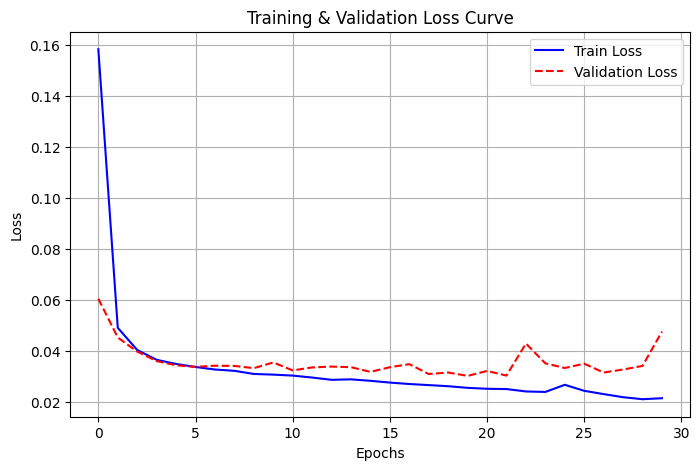

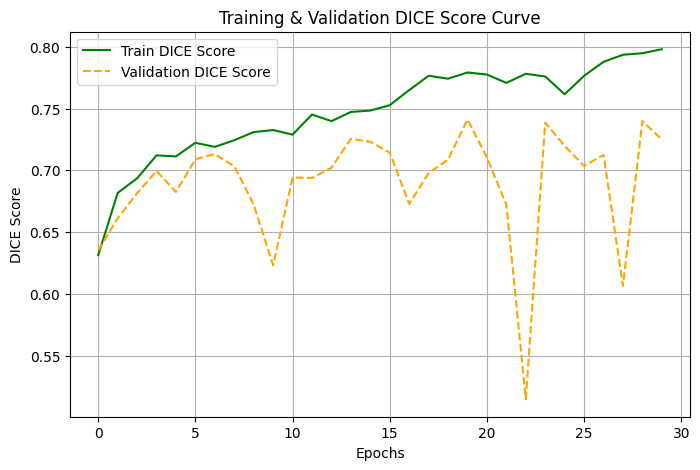

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label="Train Loss", color='blue', linestyle='-')
plt.plot(val_loss_history, label="Validation Loss", color='red', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("segmentation-loss.png", bbox_inches='tight', pad_inches=0.05, dpi=600)
plt.show()
plt.close()

# Plot DICE Score Curve
plt.figure(figsize=(8, 5))
plt.plot(train_dice_history, label="Train DICE Score", color='green', linestyle='-')
plt.plot(val_dice_history, label="Validation DICE Score", color='orange', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("DICE Score")
plt.title("Training & Validation DICE Score Curve")
plt.legend()
plt.grid(True)
plt.savefig("segmentation-dice.png", bbox_inches='tight', pad_inches=0.05, dpi=600)
plt.show()
plt.close()


Let's test the model on the test set

In [ ]:
def run_testing_loop(
    model,
    test_dataset,
    batch_size: int = 32,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    """
    Evaluates the segmentation model on the test set.

    Args:
        model (torch.nn.Module): Trained U-Net model.
        test_dataset (Dataset): Test dataset.
        batch_size (int): Batch size for testing.
        device (torch.device): Device to run inference on.

    Returns:
        Tuple:
            - mean_dice_score (float): Mean DICE score across the test set.
            - outputs (np.ndarray): Predicted segmentation masks.
            - targets (np.ndarray): Ground truth masks.
            - images (np.ndarray): Input images.
    """

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Move model to device and set to evaluation mode
    model = model.to(device)
    model.eval()

    dice_scores = []  # Store DICE scores per batch
    images, outputs, targets = [], [], []

    with torch.no_grad():
        for img, mask in test_loader:
            img = img.to(device, non_blocking=True)
            mask = mask.to(device, non_blocking=True).float().clamp(0, 1)

            # Forward Pass
            output = model(img)

            # Apply sigmoid & threshold for binary segmentation
            output = torch.sigmoid(output)
            output_bin = (output > 0.5).float()  # Convert to binary mask

            # Compute Dice Score for each batch
            dice = dice_score_fn(output_bin, mask)  # Use pre-defined dice_score_fn
            dice_scores.append(dice.item())

            # Move data to CPU and store for visualization
            images.append(img.cpu().numpy())
            outputs.append(output_bin.cpu().numpy())
            targets.append(mask.cpu().numpy())

    # Compute mean DICE score over the test set
    mean_dice_score = np.mean(dice_scores)

    # Convert to numpy arrays for easy visualization
    images = np.concatenate(images, axis=0)
    outputs = np.concatenate(outputs, axis=0)
    targets = np.concatenate(targets, axis=0)

    return mean_dice_score, outputs, targets, images

Let's calulcate the DICE score

In [ ]:
test_dataset = TumorSegmentation(
    img_dir="lgg-mri-segmentation/kaggle_3m",
    subjects=test_subjects,
    transform=None
)

dice_score, outputs, targets, images = run_testing_loop(trained_model, test_dataset, device=device)
print(f"DICE Score: {dice_score}")


DICE Score: 0.7552491747415983


Let's plot some segmentation examples

Third Best DICE Score Example Index: 63, Score: 0.9812
Fourth Best DICE Score Example Index: 272, Score: 0.9795


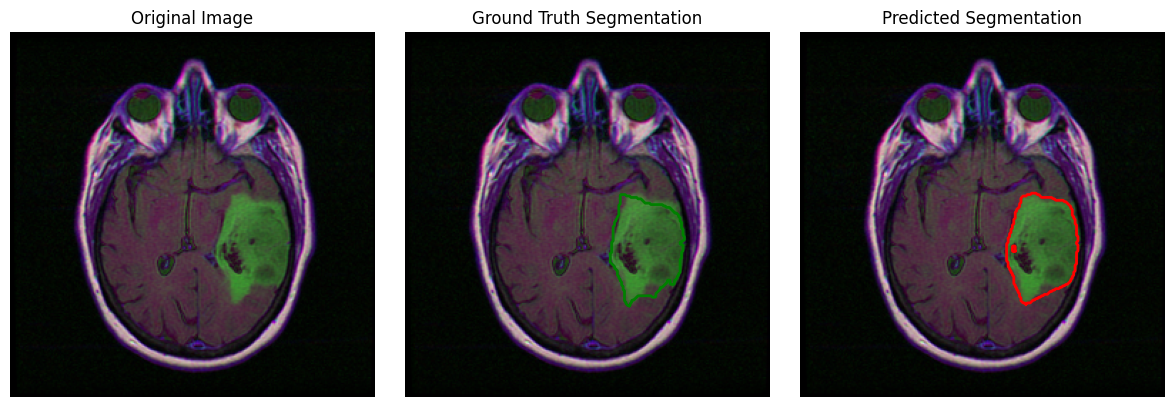

<Figure size 640x480 with 0 Axes>

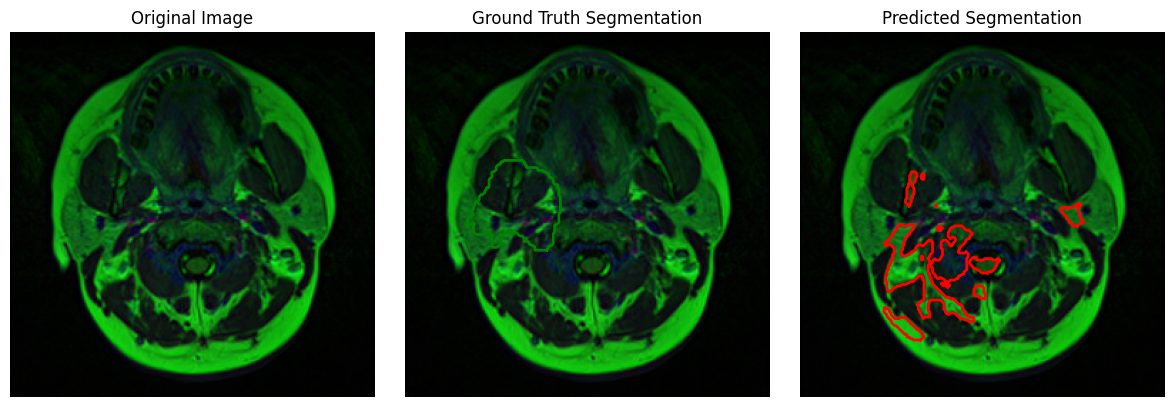

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Ensure test data exists before proceeding
if 'images' not in locals() or 'targets' not in locals() or 'outputs' not in locals():
    raise ValueError("Error: `images`, `targets`, or `outputs` not found. Please run `run_testing_loop()` first.")

# Normalize MRI images to [0,1] for proper visualization in matplotlib
def normalize_image(img):
    img = img - img.min()  # Shift min to 0
    img = img / (img.max() + 1e-8)  # Scale max to 1 (avoid division by zero)
    return img

# Compute DICE scores per test subject and filter out empty masks
valid_indices = []
dice_scores = []

for i in range(len(outputs)):
    # Check if ground truth mask has any tumor (nonzero pixels)
    if np.any(targets[i] > 0):  # Avoid empty masks
        dice = dice_score_fn(
            torch.tensor(outputs[i]).unsqueeze(0).unsqueeze(0),  # Ensure [1, 1, H, W]
            torch.tensor(targets[i]).unsqueeze(0).unsqueeze(0)   # Ensure [1, 1, H, W]
        ).item()
        valid_indices.append(i)
        dice_scores.append(dice)

# If all images are empty, raise an error
if len(valid_indices) < 4:
    raise ValueError("Not enough images with tumors found in the test set!")

# Get indices of sorted DICE scores in descending order
sorted_indices = np.argsort(dice_scores)[::-1]  # Sort from highest to lowest

# Select 3rd and 4th highest DICE score indices
third_best_idx = valid_indices[sorted_indices[2]]  # 3rd highest
fourth_best_idx = valid_indices[sorted_indices[-1]]  # 4th highest

print(f"Third Best DICE Score Example Index: {third_best_idx}, Score: {dice_scores[sorted_indices[2]]:.4f}")
print(f"Fourth Best DICE Score Example Index: {fourth_best_idx}, Score: {dice_scores[sorted_indices[3]]:.4f}")

# Convert images to suitable format for plotting
third_best_img = normalize_image(images[third_best_idx].transpose(1, 2, 0))  # [H, W, C]
third_best_target = targets[third_best_idx, 0]  # Ground truth mask
third_best_output = outputs[third_best_idx, 0]  # Predicted mask

fourth_best_img = normalize_image(images[fourth_best_idx].transpose(1, 2, 0))  # [H, W, C]
fourth_best_target = targets[fourth_best_idx, 0]
fourth_best_output = outputs[fourth_best_idx, 0]

# Plot 3rd Best Example
plot_subject_data(third_best_img, third_best_target, third_best_output)
plt.savefig("segmentation-third-best-example.png", bbox_inches='tight', pad_inches=0.05, dpi=600)
plt.show()
plt.close()

# Plot 4th Best Example
plot_subject_data(fourth_best_img, fourth_best_target, fourth_best_output)
plt.savefig("segmentation-fourth-best-example.png", bbox_inches='tight', pad_inches=0.05, dpi=600)
plt.show()
plt.close()


# **Visual Comparison of Cancerous and Healthy Tissue:**

**MRIs containing tumors:** Overlaid the irregular, hyperintense regions of distorted structure.

**Healthy MRIs:** Uniform and symmetrical brain regions with no abnormalities.

# **Why Do We Split the Data?**
**Training Set:** Optimizes model parameters.

**Validation Set:** Avoids overfitting by tuning hyperparameters.

**Testing Set:** Measures final model performance on unseen data.

# **Training Observations:**

**Training loss** decreased more rapidly than validation loss initially.

**Validation loss** continued to decrease together with training loss until validation loss started to stabilize and not further improve, at which point early stop counter started.

**Early epochs** experience oscillating and fluctuating accuracy which enhances as training progresses.

# **Learning Rate Choice Effect**


**High LR 1e-1**

Discovered that the losses oscillate uncontrollably not approaching convergence.

Accuracy did not enhance much.

**Low LR 1e-6**

Training proceeds very slowly.

Loss greatly stays stagnant with minimal improvements.

**We used** an LR of 1e-3.

# **Model Inference and Evaluation**


**Confusion Matrix:** Gives true positives, false positives, true negatives, false negatives.

**Receiver-Operator Curve (ROC) & Area Under Curve (AUC-ROC):**

Captures the model's capability to separate classes.

Higher AUC-ROC = better classification.

**Precision-Recall (PR) Curve & AUC-PR:**

Measures precision-recall tradeoff.

Crucial for imbalanced datasets.

**Accuracy:** Fraction of correct predictions.

**F1 Score:** Harmonic mean of precision & recall, weighing false positives/negatives.

**Specificity (True Negative Rate):** Measures the ability of the model to detect healthy cases.

**Sensitivity (Recall/True Positive Rate):** Measures the capability of the model to detect tumors.